
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

## Practico
### Curación y Exploración de Datos

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico. 

Dataset: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

## Importación de Librerías

In [1]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib as hl
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode

pd.set_option('display.max_columns', None)

## Lectura de Datasets

In [2]:
df_orig = pd.read_parquet("cupones_ds.parquet")
df = df_orig

In [3]:
df_infl = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Indices%20de%20inflaci%C3%B3n.csv', 
                      parse_dates=['mes'])
df_tdc = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Tipos%20de%20cambio.csv',
                     parse_dates=['fecha_cotizacion'], dayfirst=True, delimiter=';')

In [4]:
df['anio_mes_cupon'] = pd.DatetimeIndex(df['fecha_cupon_movimiento']).year * 100 + pd.DatetimeIndex(df['fecha_cupon_movimiento']).month

In [5]:
df_infl['anio_mes_infl'] = pd.DatetimeIndex(df_infl['mes']).year * 100 + pd.DatetimeIndex(df_infl['mes']).month

In [6]:
df = df.merge(df_infl[['anio_mes_infl', 'inflacion_acumulada']]
         ,left_on='anio_mes_cupon'
         ,right_on='anio_mes_infl'
         ,how='inner').drop(columns=['anio_mes_infl'])
df.loc[df.moneda_movimiento != 1,'monto_ajustado'] = \
                df[df.moneda_movimiento != 1]['monto_compra_movimiento'] / (1 + df['inflacion_acumulada'])

In [7]:
df_tdc = df_tdc.sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc['anio_mes'] = (df_tdc.fecha_cotizacion.dt.year * 100) + df_tdc.fecha_cotizacion.dt.month
df_tdc.head(10)

,fecha_cotizacion,compra,venta,anio_mes
0,2020-03-10,59.00,64.00,202003
1,2020-03-11,59.00,64.00,202003
2,2020-03-12,59.50,64.50,202003
3,2020-03-13,59.50,64.50,202003
4,2020-03-16,59.50,64.50,202003
5,2020-03-17,59.50,64.50,202003
6,2020-03-18,60.00,65.00,202003
7,2020-03-19,60.00,65.00,202003
8,2020-03-20,60.00,65.00,202003
9,2020-03-25,60.25,65.25,202003


In [8]:
df_tdc['day'] = df_tdc.fecha_cotizacion.dt.day

In [9]:
meses_cdiez = df_tdc[df_tdc['day'].isin([10])]['anio_mes'].unique()
meses_sdiez = df_tdc[(~df_tdc['day'].isin([10])) & (~df_tdc['anio_mes'].isin(meses_cdiez))]['anio_mes'].unique()

ind_fechas = []

for i in meses_cdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] == 10)]['fecha_cotizacion'].index)))
for i in meses_sdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] > 10)]['fecha_cotizacion'].index)))

ind_fechas

[0, 59, 99, 121, 162, 181, 221, 239, 279, 300, 19, 38, 79, 143, 199, 259]

In [10]:
df_tdc_cot = df_tdc.iloc[ind_fechas,:].sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc_cot

,fecha_cotizacion,compra,venta,anio_mes,day
0,2020-03-10,59.00,64.00,202003,10
1,2020-04-13,61.75,66.75,202004,13
2,2020-05-11,64.25,69.25,202005,11
3,2020-06-10,66.50,71.50,202006,10
4,2020-07-13,69.50,74.50,202007,13
5,2020-08-10,72.00,77.00,202008,10
6,2020-09-10,74.00,79.00,202009,10
7,2020-10-13,76.25,82.25,202010,13
8,2020-11-10,78.75,84.75,202011,10
9,2020-12-10,81.50,87.50,202012,10


In [11]:
df.fecha_cupon_movimiento = pd.to_datetime(df.fecha_cupon_movimiento)

In [12]:
def func_var(row):
    if row.fecha_cupon_movimiento.day > 24:
        if row.fecha_cupon_movimiento.month == 12:
            return 202101
        else:
            return row['anio_mes_cupon'] + 1
    else:
        return row['anio_mes_cupon']

In [13]:
df.loc[df.moneda_movimiento == 1,'anio_mes_cupon'] = df[df.moneda_movimiento == 1].apply(func_var, axis=1)

In [14]:
df[df.moneda_movimiento == 1][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
3111,2020-08-02,202008
3120,2020-08-02,202008
3130,2020-08-02,202008
3196,2020-08-02,202008
3465,2020-08-07,202008


In [15]:
df[(df.moneda_movimiento == 1) & (df.fecha_cupon_movimiento.dt.day >= 25)  & (df.fecha_cupon_movimiento.dt.month >= 12)][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
1801620,2020-12-25,202101
1801621,2020-12-27,202101
1801627,2020-12-27,202101
1801636,2020-12-31,202101
1801649,2020-12-27,202101


In [16]:
df = df.merge(df_tdc_cot[['anio_mes', 'venta']].drop_duplicates()
                 ,left_on='anio_mes_cupon'
                 ,right_on='anio_mes'
                 ,how='inner').drop(columns=['anio_mes'])

In [17]:
df.loc[df.moneda_movimiento == 1,'monto_ajustado'] = \
                df[df.moneda_movimiento == 1]['monto_compra_movimiento'] * df['venta']

In [18]:
df[df.moneda_movimiento == 1][['monto_compra_movimiento','monto_ajustado']]

,monto_compra_movimiento,monto_ajustado
3111,-3.50,-269.50
3120,-33.00,-2541.00
3130,-34.08,-2624.16
3196,-200.23,-15417.71
3465,0.16,12.32
...,...,...
4091520,-0.09,-9.00
4091521,-0.09,-9.00
4091522,-0.09,-9.00
4091523,-0.09,-9.00


En este punto, ya tenemos todas las columnas que necesitamos para nuestros próximos análisis:
* Ajuste sobre inflación para los montos de pesos y zeta.
* Conversión a moneda peso de los importes en dolares utilizando el tipo de cambio vendedor vigente al día de vencimiento del resumen de la tarjeta.

In [48]:
df = df.drop(columns=['anio_mes_cupon','inflacion_acumulada','venta'])

In [49]:
df['monto_ajustado'] = df['monto_ajustado'].round(2)

Quedamos con el dataset transformado y las columnas que vamos a usar.

## 1. Curación
Con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático

* Asegurar IDs únicos
  > Ejm. `id_comercio_movimiento` le corresponde un mismo `nombre_comercio_histo`?
* Asegurar que el codigo postal tenga el tipo de datos correcto.
* Tratamiento de valores Sensibles
  > Ejm. cuando se tienen datos como el DNI, CUIL o Nro de Tarjetas correponde a datos confidenciales
  - Codifcar los valores usando el algoritmo `sha256` con la libreria `hashlib`
* Reemplazar caracteres especiales. Ejm
  ```
  ñ. Ñ. ~. ç. Ç. á. é. í. ó. ú. Á. É. Í. Ó. Ú. ü. Ü.
  @. ¡ ! ¿ ? ⁄. \. °. —. (. ) [. ] {. } 〈. 〉 ‹ › <. > 
  〔. 〕 « » ¹. ². ³ … ˜. §. ¶.  †. “ ” ∞. µ. à.
  ```
* Asegurar que las fechas tengan el formato ISO 8601, `YYYY-MM-DD`
* Agrupar valores de `cargo_descripcion_histo`.
  > Ejm. si tenemos un valor con`vigilador` y otro `sereno`, estos corresponden a una misma categoria., 

In [3]:
df.columns

Index(['dni_titular_movimiento', 'moneda_movimiento', 'id_comercio_movimiento',
       'nombre_comercio_histo', 'numero_cupon_movimiento',
       'debito_credito_movimiento', 'producto_naranja_movimiento',
       'codigo_empresa_movimiento', 'tipo_producto_tarjeta_movimiento',
       'plan_movimiento', 'fecha_vto_cupon_movimiento',
       'fecha_presentacion_movimiento', 'fecha_cupon_movimiento',
       'fecha_carga_sistema_movimiento', 'monto_compra_movimiento',
       'importe_cuota_movimiento', 'interes_movimiento',
       'cargo_adm_seguro_movimiento', 'cargo_otorgamiento_movimiento',
       'cargo_seguro_vida_movimiento', 'cargo_administrativo_movimiento',
       'seleccionado_ng', 'tipo_prestamo_movimiento',
       'codigo_contable_movimiento', 'local_venta_producto',
       'nombre_local_histo', 'marca_debito_automatico',
       'fecha_extraccion_movimiento', 'id_comercio_otras_marcas_movimiento',
       'fecha_nacimiento', 'estado_civil_descripcion', 'sexo_descripcion',
       

### 1.1. Asegurar IDs únicos

In [4]:
df['id_comercio_movimiento'].value_counts() # 3833 valores unicos para id_comercio

958705120    464301
20099902     415104
20089993     359283
20099745     239775
20099760     194994
              ...  
380028770        15
115052555        15
840017948        15
20101264         14
64194852          5
Name: id_comercio_movimiento, Length: 3833, dtype: int64

In [5]:
# Aca deberia haber 2 'TARJETA NARANJA SUBTE'

df[df['nombre_comercio_histo'].str.contains('TARJETA NARANJA SUBTE')] \
                                        [['id_comercio_movimiento','nombre_comercio_histo']] \
                                        .drop_duplicates()

,id_comercio_movimiento,nombre_comercio_histo
22913,10099033,TARJETA NARANJA SUBTE
97058,10099033,TARJETA NARANJA SUBTE


In [6]:
# Reagrupar los comercios que tienen mas de un nombre y concatenar todos sus nombres

df.nombre_comercio_histo = df.nombre_comercio_histo.str.strip()

df_unicos = (
    df[["id_comercio_movimiento", "nombre_comercio_histo"]].drop_duplicates()
        .groupby("id_comercio_movimiento")
        .sum()
).reset_index()

In [7]:
df_unicos = df_unicos.rename(columns={'nombre_comercio_histo':'nombre_comercio_concat'})
df_unicos

,id_comercio_movimiento,nombre_comercio_concat
0,10099033,TARJETA NARANJA SUBTE
1,10099058,TARJETA NARANJA SUCRE
2,10099814,TARJETA NARANJA SAN VICENTE
3,20080001,PAGO ANULADO POR VERIFICACION
4,20089993,IMPUESTO SELLOS
...,...,...
3828,991085968,PUERTO TERNURAS
3829,991097830,PEQUE&OS SUE&OS
3830,991108260,DISCO SM 156
3831,991108624,JUMBO MOR�N


Reagrupamos los comercios que tienen mas de un nombre y concatenamos todos sus nombres en una nueva columna **nombre_comercio_concat**

In [8]:
# Unimos con dataframe original agregando la columna nueva con relacion 1:1 con el id
df = df.merge(df_unicos, on='id_comercio_movimiento', how='inner')

In [9]:
# Relacion 1:1 entre id_comercio_movimiento y la columna nueva con los nombres concatenados
df[['id_comercio_movimiento', 'nombre_comercio_concat']].drop_duplicates() \
.groupby(['id_comercio_movimiento']).count() # Deberia dar 3833 que es la cantidad de ids unicos

,nombre_comercio_concat
id_comercio_movimiento,
10099033,1
10099058,1
10099814,1
20080001,1
20089993,1
...,...
991085968,1
991097830,1
991108260,1


El dataframe contiene una relacion 1:N correspondiente a **id_comercio** y a **nombre_comercio**. Estudiando casos donde esto ocurre, observamos que se debe a dos razones:
* Por un lado, los nombres pueden contener distintos caracteres especiales en cada caso. 
* Por otro lado, un mismo **id_comercio** puede haber cambiado su razón social a lo largo del tiempo.
---
Para solventar estos problemas, se aplicó la funcion ´strip()´ que se encarga de eliminar los caracteres especiales. 
Para los casos donde hubo cambio de razón social, se concatenaron en una nueva columna **nombre_comercio_concat**. De esta manera se pierde la diferencia entre los distintos nombres asociados a ese id pero se gana la relacion 1:1 entre id y nombre.

Mostramos un ejemplo de un **id_comercio_movimiento**, donde tenemos 4 razones sociales asociadas a un mismo id, y el resultado luego de la transformación realizada.

In [10]:
# Caso donde tenemos 4 nombres asociados a un mismo id, y el resultado luego de la transformacion realizada

df[df['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento', 'nombre_comercio_histo', 'nombre_comercio_concat']]

,id_comercio_movimiento,nombre_comercio_histo,nombre_comercio_concat
3901719,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901720,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901721,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901722,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3901723,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
...,...,...,...
3903094,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903095,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903096,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3903097,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...


### 1.2. Asegurar el tipo de dato de codigo postal

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092008 entries, 0 to 4092007
Data columns (total 46 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   dni_titular_movimiento               object        
 1   moneda_movimiento                    int64         
 2   id_comercio_movimiento               int64         
 3   nombre_comercio_histo                object        
 4   numero_cupon_movimiento              int64         
 5   debito_credito_movimiento            int64         
 6   producto_naranja_movimiento          object        
 7   codigo_empresa_movimiento            int64         
 8   tipo_producto_tarjeta_movimiento     int64         
 9   plan_movimiento                      int64         
 10  fecha_vto_cupon_movimiento           object        
 11  fecha_presentacion_movimiento        object        
 12  fecha_cupon_movimiento               datetime64[ns]
 13  fecha_carga_sistema_movimie

In [29]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)

In [30]:
df.domicilio_codigo_postal

0          1766
1          5521
2          7107
3          2200
4          1019
           ... 
4092003    4200
4092004    4200
4092005    4200
4092006    4200
4092007    4200
Name: domicilio_codigo_postal, Length: 4092008, dtype: object

En el dataset original la columna de **domicilio_codigo_postal** tiene un formato float64.
El código postal es un número, pero no se deberían de poder hacer cálculos sobre el mismo, por lo cual se la considera una variable Categórica, y se la convierte en String para quitarle los decimales y además, impedir que se puedan hacer cálculos sobre él.

### 1.3. Tratamiento de datos sensibles

Codifcar los valores usando el algoritmo sha256 con la libreria hashlib

In [31]:
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,inflacion_acumulada,monto_ajustado,venta,nombre_comercio_concat
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,0.131,5.517241,77.0,INTERES POR MORA U$S
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,None,None,202008,0.131,15.676393,77.0,INTERES POR MORA U$S
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,0.131,5.464191,77.0,INTERES POR MORA U$S
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,0.131,2.502210,77.0,INTERES POR MORA U$S
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,202008,0.131,2.104332,77.0,INTERES POR MORA U$S


Analizando el dataset, podemos observar que el dato más sensible es **dni_titular_movimiento**.

Se trabajó sobre una copia del Dataframe Original, ya que, este ejercicio tuvo el objetivo de practicar el algoritmo de encriptación SHA256.

In [51]:
df_testing_dni = df
df_testing_dni['dni_titular_movimiento'] = df_testing_dni['dni_titular_movimiento'].str.strip()
df_testing_dni['dni_titular_movimiento'] = [hl.sha256(val.encode("utf8")).hexdigest() for val in df_testing_dni['dni_titular_movimiento']]
df_testing_dni.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,monto_ajustado,nombre_comercio_concat
0,f2fe6d30ff71cec44199b766503061b83dcbbdd3ac50a0...,0,20099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1959-07-18,Divorciadoa,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,5.52,INTERES POR MORA US
1,0387413b14d1e6a41d6a40aa75d540bde54ff368c19c1c...,0,20099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VANVA DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,15.68,INTERES POR MORA US
2,9e08edff83d3b164aa017929eaf3a1f121cd79abe012a6...,0,20099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1992-07-29,Solteroa,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,5.46,INTERES POR MORA US
3,103c6da83103fd0312732b0b614e93a3c7f359107528a1...,0,20099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1980-11-01,Solteroa,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,2.50,INTERES POR MORA US
4,afc269c6ea8aee0e8a96b7c9fe1b761fb65b94c23ce6f7...,0,20099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1984-03-08,Solteroa,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,2.10,INTERES POR MORA US


Observamos que la columna **dni_titular_movimiento** ha quedado encriptada bajo el algoritmo sha256.

### 1.4. Reemplazar caracteres especiales

In [33]:
import re

In [34]:
columnas_str = [
    'nombre_comercio_histo',
    'producto_naranja_movimiento',
    'nombre_local_histo',
    'estado_civil_descripcion',
    'sexo_descripcion',
    'pais',
    'provincia',
    'ciudad',
    'domicilio_barrio',
    'cargo_descripcion_histo',
    'nivel_estudio_descripcion_histo',
    'rel_vivienda_descripcion_histo',
    'nombre_comercio_concat'
]

In [35]:
unidecode(u'Ñ')

'N'

In [36]:
regex = r'[^a-zA-Z0-9 ]'

In [37]:
print(df.iloc[920325]['nombre_local_histo'])
print(df.iloc[3977032]['nombre_local_histo'])
print(df.iloc[3977032]['nombre_comercio_histo'])

None
TARJETA NARANJA LA RIOJA
TARJETA NARANJA LA RIOJA


In [38]:
for col in columnas_str:
    df[col] = df[df[col].isnull()==False][col].apply(unidecode)

In [39]:
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,inflacion_acumulada,monto_ajustado,venta,nombre_comercio_concat
0,ab13f4e1b1c8194051b1dd6da7643b6863500750713f8e...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,0.131,5.517241,77.0,INTERES POR MORA U$S
1,e77952e42b7136528a7169e75706a24427288b34df5d5c...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,202008,0.131,15.676393,77.0,INTERES POR MORA U$S
2,d3a2291efdc4b3d6eb1b521e6b945c279b37669f36add0...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,0.131,5.464191,77.0,INTERES POR MORA U$S
3,ac9b1c68c368d72d18332dee7a9c022ca1f568d9d33962...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,0.131,2.502210,77.0,INTERES POR MORA U$S
4,7761d75e3579c455c20a7156cfc10b68c4acc37fe6b5cc...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,NaN,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,202008,0.131,2.104332,77.0,INTERES POR MORA U$S


In [40]:
for col in columnas_str:
    df.loc[:, col] = df[col].str.replace(regex, '')

<ipython-input-40-613ea7a0b290>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, col] = df[col].str.replace(regex, '')


In [41]:
print(df.iloc[920325]['nombre_local_histo'])
print(df.iloc[3977032]['nombre_local_histo'])
print(df.iloc[3977032]['nombre_comercio_histo'])

nan
TARJETA NARANJA LA RIOJA
TARJETA NARANJA LA RIOJA


### 1.5. Asegurar formato de fecha

In [22]:
# Columnas con fecha

col_fechas = [
    'fecha_vto_cupon_movimiento',
    'fecha_presentacion_movimiento',
    'fecha_cupon_movimiento',
    'fecha_carga_sistema_movimiento',
    'fecha_nacimiento',
    'fecha_extraccion_movimiento',
    'fecha_de_ingreso_histo'
]

df_fchs = df[col_fechas]
df_fchs

,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,fecha_nacimiento,fecha_extraccion_movimiento,fecha_de_ingreso_histo
0,2020-09-10,2020-08-25,2020-08-25,None,1959-07-18,NaN,2012-12-11
1,2020-09-10,2020-08-25,2020-08-25,None,1991-06-28,NaN,2020-06-10
2,2020-09-10,2020-08-25,2020-08-25,None,1992-07-29,NaN,2012-09-13
3,2020-09-10,2020-08-25,2020-08-25,None,1980-11-01,NaN,2008-01-15
4,2020-09-10,2020-08-25,2020-08-25,None,1984-03-08,NaN,2013-06-06
...,...,...,...,...,...,...,...
4092072,2021-05-10,2021-04-20,2021-04-22,2021-04-21,1985-09-16,NaN,2014-04-04
4092073,2021-05-10,2021-04-20,2021-04-20,2021-04-21,1985-09-16,NaN,2014-04-04
4092074,2021-05-10,2021-04-20,2021-04-22,2021-04-21,1985-09-16,NaN,2014-04-04
4092075,2021-05-10,2021-04-20,2021-04-20,2021-04-21,1985-09-16,NaN,2014-04-04


In [24]:
df_fchs.isnull().sum()

fecha_vto_cupon_movimiento              0
fecha_presentacion_movimiento           0
fecha_cupon_movimiento                  0
fecha_carga_sistema_movimiento    1404647
fecha_nacimiento                    10551
fecha_extraccion_movimiento       4092077
fecha_de_ingreso_histo                  0
dtype: int64

In [25]:
df[col_fechas] = df[col_fechas].apply(pd.to_datetime)

c:\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [26]:
df_fchs["fecha_cupon_movimiento"]

0          2020-08-25
1          2020-08-25
2          2020-08-25
3          2020-08-25
4          2020-08-25
              ...    
4092072    2021-04-22
4092073    2021-04-20
4092074    2021-04-22
4092075    2021-04-20
4092076    2021-04-22
Name: fecha_cupon_movimiento, Length: 4092077, dtype: object

In [27]:
df.loc[:,col_fechas] = df_fchs

### 1.6. Agrupar valores de cargo_descripcion_histo

In [29]:
df['cargo_descripcion_histo'].nunique()

25

In [30]:
df['cargo_descripcion_histo'].unique()

array(['EMPDE COMERCIO', 'SIN DATOS', 'INDEPENDIENTE', 'ENFERMERO',
       'EMPSEGPUBLICA', 'DOCENTE', 'ADMINISTRATIVO', 'VIGILADOR',
       'PROPIETARIO', 'CHOFER', 'MAESTRANZA', 'VENDEDORPROMOT',
       'PRESTCREDITO', 'JUBILADO', 'OPERARIO', 'PROFESTECNICO', 'MOZO',
       'ENCARGADO', 'PEONEMBARCADOS', 'JEFE', 'CAJERO', 'PORTEROCONSERJ',
       'COCINERO', 'PRESGARANTIA', 'MEDICO'], dtype=object)

In [31]:
df[df['cargo_descripcion_histo'].isna() == True]['cargo_descripcion_histo'].count()

0

In [32]:
df[['cargo_descripcion_histo']].groupby(by=['cargo_descripcion_histo']).size().to_frame()

,0
cargo_descripcion_histo,
ADMINISTRATIVO,198845
CAJERO,15636
CHOFER,36165
COCINERO,2829
DOCENTE,233485
EMPDE COMERCIO,500519
EMPSEGPUBLICA,107489
ENCARGADO,9381
ENFERMERO,14146


Podemos agrupar:
* Sector Salud: Enfermero, Medico.
* Sector Educativo: Docente, Profestecnico
* Sector Seguridad: EmpSegPublica, PorteroConserj, Vigilador
* Sector Financiero: PRESGARANTIA, PRESTCREDITO
* Sector Gastronómico: Cocinero, Mozo
* Sector Empleados de Comercio: Administrativo, Cajero, EMPDE COMERCIO, Maestranza, Jefe, Encargado, VENDEDORPROMOT
* Sector Operativo: Chofer, Independiente, Operario, PEONEMBARCADOS, Propietario.
* Sector No Operativo: Jubilados.
* Sin Datos: Sin Datos.

In [33]:
sec_salud = ['ENFERMERO','MEDICO']
sec_edu = ['DOCENTE','PROFESTECNICO']
sec_seg = ['EMPSEGPUBLICA','PORTEROCONSERJ','VIGILADOR']
sec_fin = ['PRESGARANTIA','PRESTCREDITO']
sec_gast = ['COCINERO','MOZO']
sec_Emp_Com = ['ADMINISTRATIVO','CAJERO','EMPDE COMERCIO','MAESTRANZA','JEFE','ENCARGADO','VENDEDORPROMOT']
sec_ope = ['CHOFER','INDEPENDIENTE','OPERARIO','PEONEMBARCADOS','PROPIETARIO']
sec_no_ope = ['JUBILADO']
sec_sd = ['SIN DATOS']

df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_salud)),'cargo_secor_desc_hist'] = 'Sector_Salud'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_edu)),'cargo_secor_desc_hist'] = 'Sector_Educativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_seg)),'cargo_secor_desc_hist'] = 'Sector_Seguridad'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_fin)),'cargo_secor_desc_hist'] = 'Sector_Financiero'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_gast)),'cargo_secor_desc_hist'] = 'Sector_Gastronomico'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_Emp_Com)),'cargo_secor_desc_hist'] = 'Sector_Empleado_Comercio'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_ope)),'cargo_secor_desc_hist'] = 'Sector_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_no_ope)),'cargo_secor_desc_hist'] = 'Sector_No_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_sd)),'cargo_secor_desc_hist'] = 'Sector_Sin_Datos'

In [34]:
df[['cargo_descripcion_histo','cargo_secor_desc_hist']].drop_duplicates()

,cargo_descripcion_histo,cargo_secor_desc_hist
0,EMPDE COMERCIO,Sector_Empleado_Comercio
1,SIN DATOS,Sector_Sin_Datos
6,INDEPENDIENTE,Sector_Operativo
7,ENFERMERO,Sector_Salud
10,EMPSEGPUBLICA,Sector_Seguridad
12,DOCENTE,Sector_Educativo
21,ADMINISTRATIVO,Sector_Empleado_Comercio
29,VIGILADOR,Sector_Seguridad
2623,PROPIETARIO,Sector_Operativo
2639,CHOFER,Sector_Operativo


In [35]:
df[['cargo_secor_desc_hist']].groupby(by=['cargo_secor_desc_hist']).size().to_frame().sort_values(by=0, ascending=False)

,0
cargo_secor_desc_hist,
Sector_Sin_Datos,2044855
Sector_Empleado_Comercio,851532
Sector_Operativo,359928
Sector_No_Operativo,349071
Sector_Educativo,279277
Sector_Seguridad,123239
Sector_Financiero,62922
Sector_Salud,14836
Sector_Gastronomico,6417


## 2. Data enrichment
* obtener edad usando la columna `fecha_nacimiento` y `fecha_cupon_movimiento`
* obtener antiguedad usando la columna `fecha_de_ingreso_histo` y `fecha_cupon_movimiento` en termino de meses
* usando la columna `nombre_comercio_histo` crear una nueva columna clasificando el tipo de "comercio". Ejemplo 
   ```
     COMISION POR MANTENIM.DE CTA., IMPUESTO SELLOS, INT.PAGO FUERA TERMINO ------> Categoria A
     MERCADO PAGO, DESPEGAR.COM                                             ------> Categoria B
   ```
   > Crear un minimo de 5 categorias
* se puede aplicar el proceso anterior a la columna `nombre_local_histo` y `cargo_descripcion_histo`. Aportaria informacion relevante?

### 2.1. Cálculo de la edad de la persona

El cálculo de la edad se debe efectuar con la fecha_nacimiento y fecha_cupon_movimiento.

In [35]:
df['fecha_cupon_movimiento'] = pd.to_datetime(df.fecha_cupon_movimiento)
df['fecha_nacimiento'] = pd.to_datetime(df.fecha_nacimiento)

In [36]:
df = df.fillna(value=np.nan)
df['edad_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_nacimiento'])/np.timedelta64(1, 'Y'))
df.edad_cliente = df[df['edad_cliente'].isna()!=True]['edad_cliente'].apply(int)
df 

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,edad_cliente
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,61.0
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,29.0
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,28.0
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,39.0
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,00087cefbeb57961569988d7403d45a8135,0,30093930,TARJETA NARANJA TUCUMAN CRISOS,373205,0,PL,1,3,1,2021-03-10,2021-02-03,2021-02-03,2021-02-03,2.29,2.29,0.0,0.0,0.0,0.0,0.0,0,NaN,2599,30093930,TARJETA NARANJA TUCUMAN CRISOSTOMO,0,NaN,0,1950-09-05,Casado/a,Mujer,Argentina,TUCUMAN,TUCUMAN,4000.0,MZ.3-TORRE A-24 DE SETIEMBRE-TUCUMAN,2016-01-06,SIN DATOS,SECUNDARIOS,NaN,70.0
4092073,0007e89e7180b18b18951a4c9de5419f943,0,30095787,TARJETA NARANJA SAN ISIDRO,210118,0,PL,1,22,1,2021-02-10,2021-01-25,2021-01-25,2021-01-19,229.90,229.90,0.0,0.0,0.0,0.0,0.0,0,NaN,309,30095787,TARJETA NARANJA SAN ISIDRO,0,NaN,0,1991-10-16,Sin Datos,Mujer,Argentina,BUENOS AIRES,OLIVOS (Buenos Aires),1636.0,VICENTE LOPEZ,2018-10-08,SIN DATOS,NaN,NaN,29.0
4092074,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,760582,0,PL,1,3,1,2020-10-10,2020-09-02,2020-09-02,2020-09-02,4.64,4.64,0.0,0.0,0.0,0.0,0.0,0,NaN,2599,30096987,TARJETA NARANJA GRAL ALVEAR,0,NaN,0,1960-06-05,Divorciado/a,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia,60.0
4092075,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,761648,0,PL,1,3,1,2020-12-10,2020-11-02,2020-11-02,2020-11-02,12.22,12.22,

In [46]:
df.isna().sum()

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

In [47]:
df.edad_cliente.describe().round(2)

count    4081526.00
mean          49.17
std           15.14
min           18.00
25%           36.00
50%           47.00
75%           61.00
max          109.00
Name: edad_cliente, dtype: float64

### Cálculo de la antigüedad de la persona

In [37]:
df['fecha_de_ingreso_histo'] = pd.to_datetime(df.fecha_de_ingreso_histo)

In [38]:
df['antig_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_de_ingreso_histo'])/np.timedelta64(1, 'M'))
df['antig_cliente']= df.antig_cliente.apply(int)
df

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,edad_cliente,antig_cliente
0,0001686b52949b5461ffcbc766687e45031,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766.0,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,61.0,92
1,000220fa96ec5af89817894033f8099c547,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521.0,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,29.0,2
2,0002be202de47dfae9cc2304d91161be595,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107.0,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,28.0,95
3,000e137d0af42e193be1ff670c00d4d1506,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200.0,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,39.0,151
4,0009d010e4faf69552a814a33832b185877,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,NaN,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,NaN,281,20099784,NaN,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019.0,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,36.0,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,00087cefbeb57961569988d7403d45a8135,0,30093930,TARJETA NARANJA TUCUMAN CRISOS,373205,0,PL,1,3,1,2021-03-10,2021-02-03,2021-02-03,2021-02-03,2.29,2.29,0.0,0.0,0.0,0.0,0.0,0,NaN,2599,30093930,TARJETA NARANJA TUCUMAN CRISOSTOMO,0,NaN,0,1950-09-05,Casado/a,Mujer,Argentina,TUCUMAN,TUCUMAN,4000.0,MZ.3-TORRE A-24 DE SETIEMBRE-TUCUMAN,2016-01-06,SIN DATOS,SECUNDARIOS,NaN,70.0,60
4092073,0007e89e7180b18b18951a4c9de5419f943,0,30095787,TARJETA NARANJA SAN ISIDRO,210118,0,PL,1,22,1,2021-02-10,2021-01-25,2021-01-25,2021-01-19,229.90,229.90,0.0,0.0,0.0,0.0,0.0,0,NaN,309,30095787,TARJETA NARANJA SAN ISIDRO,0,NaN,0,1991-10-16,Sin Datos,Mujer,Argentina,BUENOS AIRES,OLIVOS (Buenos Aires),1636.0,VICENTE LOPEZ,2018-10-08,SIN DATOS,NaN,NaN,29.0,27
4092074,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,760582,0,PL,1,3,1,2020-10-10,2020-09-02,2020-09-02,2020-09-02,4.64,4.64,0.0,0.0,0.0,0.0,0.0,0,NaN,2599,30096987,TARJETA NARANJA GRAL ALVEAR,0,NaN,0,1960-06-05,Divorciado/a,Mujer,Argentina,MENDOZA,GENERAL ALVEAR,5620.0,Y EVA DUARTE,2019-08-06,SIN DATOS,PRIMARIOS,Propia,60.0,12
4092075,00015797a6f53e90f66ae237a1157054062,0,30096987,TARJETA NARANJA GRAL ALVEAR,761648,0,PL,1,3,1,2020-12-10,202

In [50]:
df.antig_cliente.describe().round(2)

count    4092077.00
mean         112.62
std           79.23
min            0.00
25%           47.00
50%           97.00
75%          169.00
max          390.00
Name: antig_cliente, dtype: float64

## 3. Exploración

* Analisis de valores Nulos
  - Existen columnas en donde se prodria hacer imputacion de valores? Si es asi, imputar los valores.
  - Para aquellos en donde no aplique lo primero, conviene eliminarlos o agruparlos como otro valor?
* Identificar valores atípicos.
  * Para variables numericas, analisis de outliers. En que caso se pueden eliminar estos valores?
  * Para variables categoricas, se pueden agrupar estos valores en una nueva categoria?
    > Ejm. `cargo_descripcion_histo`
  * Para fechas. existen fechas atipicas?
    > Ejm. Una fecha con el valor `2021-12-03`, sabiendo que el dataset deberia tener  datos entre julio 2020 y mayo 2021 
* Se puede normalizar la antiguedad y/o `monto_compra_movimiento`?
* Usando la edad y la antiguerdad hacer una analisis de PCA junto con la variables `monto_compra_movimiento`
  > pueden usar las 3 variables o hacer un analisis edad - monto y antiguedad - monto.

### Análisis de Datos Nulos

In [59]:
df.shape

(4092077, 43)

In [60]:
missing_values_count = df.isna().sum()
missing_values_count

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

In [ ]:
ax = msno.bar(df,figsize=(12, 6), fontsize=12, color='steelblue')
ax.tick_params('x', rotation=90)

In [ ]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

#### Tipo_prestamo_movimiento, Nombre_local_histo y Fecha_extraccion_movimiento 

Las variables tipo_prestamo_movimiento, nombre_local_histo y fecha_extraccion_movimiento poseen una pérdida muy alta de valores (fecha extracción tiene todos valores nulos), por lo cuál la mejor decisión seria no tenerlas en cuenta en los siguientes análisis.

In [61]:
df_drop = df.drop(columns = ['tipo_prestamo_movimiento','nombre_local_histo','fecha_extraccion_movimiento']) 
df_drop.shape

(4092077, 40)

In [ ]:
#usamos sample porque da error con todo el datas
df_ms = df_drop.sample(10000)
ax = msno.matrix(df_ms,figsize=(12, 6),fontsize=12)
ax.tick_params('x', rotation=90)

Se puede observar cierta sistematicidad en la pérdida de valores relacionados a datos personales de los clientes. A continuación procedemos a analizar cada columna con valores faltantes.

#### Datos Faltantes Personales de los clientes

In [62]:
df_faltante_fech= pd.DataFrame(df_drop[df_drop['fecha_nacimiento'].isna()])
df_faltante_fech.isna().sum()

dni_titular_movimiento                     0
moneda_movimiento                          0
id_comercio_movimiento                     0
nombre_comercio_histo                      0
numero_cupon_movimiento                    0
debito_credito_movimiento                  0
producto_naranja_movimiento                0
codigo_empresa_movimiento                  0
tipo_producto_tarjeta_movimiento           0
plan_movimiento                            0
fecha_vto_cupon_movimiento                 0
fecha_presentacion_movimiento              0
fecha_cupon_movimiento                     0
fecha_carga_sistema_movimiento          2484
monto_compra_movimiento                    0
importe_cuota_movimiento                   0
interes_movimiento                         0
cargo_adm_seguro_movimiento                0
cargo_otorgamiento_movimiento              0
cargo_seguro_vida_movimiento               0
cargo_administrativo_movimiento            0
seleccionado_ng                            0
codigo_con

In [63]:
df_faltante_fech.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000650e8144e3a42d47a21aee9e48f34804    1380
000b0d85fa8a959e2133328830fff990443     690
Name: dni_titular_movimiento, dtype: int64

In [64]:
dni859 = df_drop[(df_drop["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]
dni859.isna().sum()

dni_titular_movimiento                    0
moneda_movimiento                         0
id_comercio_movimiento                    0
nombre_comercio_histo                     0
numero_cupon_movimiento                   0
debito_credito_movimiento                 0
producto_naranja_movimiento               0
codigo_empresa_movimiento                 0
tipo_producto_tarjeta_movimiento          0
plan_movimiento                           0
fecha_vto_cupon_movimiento                0
fecha_presentacion_movimiento             0
fecha_cupon_movimiento                    0
fecha_carga_sistema_movimiento         1380
monto_compra_movimiento                   0
importe_cuota_movimiento                  0
interes_movimiento                        0
cargo_adm_seguro_movimiento               0
cargo_otorgamiento_movimiento             0
cargo_seguro_vida_movimiento              0
cargo_administrativo_movimiento           0
seleccionado_ng                           0
codigo_contable_movimiento      

In [65]:
dni804 = df_drop[(df_drop["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804")]
dni804.isna().sum()

dni_titular_movimiento                    0
moneda_movimiento                         0
id_comercio_movimiento                    0
nombre_comercio_histo                     0
numero_cupon_movimiento                   0
debito_credito_movimiento                 0
producto_naranja_movimiento               0
codigo_empresa_movimiento                 0
tipo_producto_tarjeta_movimiento          0
plan_movimiento                           0
fecha_vto_cupon_movimiento                0
fecha_presentacion_movimiento             0
fecha_cupon_movimiento                    0
fecha_carga_sistema_movimiento         1104
monto_compra_movimiento                   0
importe_cuota_movimiento                  0
interes_movimiento                        0
cargo_adm_seguro_movimiento               0
cargo_otorgamiento_movimiento             0
cargo_seguro_vida_movimiento              0
cargo_administrativo_movimiento           0
seleccionado_ng                           0
codigo_contable_movimiento      

In [66]:
dni443 = df_drop[(df_drop["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443")]
dni443.isna().sum()

dni_titular_movimiento                   0
moneda_movimiento                        0
id_comercio_movimiento                   0
nombre_comercio_histo                    0
numero_cupon_movimiento                  0
debito_credito_movimiento                0
producto_naranja_movimiento              0
codigo_empresa_movimiento                0
tipo_producto_tarjeta_movimiento         0
plan_movimiento                          0
fecha_vto_cupon_movimiento               0
fecha_presentacion_movimiento            0
fecha_cupon_movimiento                   0
fecha_carga_sistema_movimiento           0
monto_compra_movimiento                  0
importe_cuota_movimiento                 0
interes_movimiento                       0
cargo_adm_seguro_movimiento              0
cargo_otorgamiento_movimiento            0
cargo_seguro_vida_movimiento             0
cargo_administrativo_movimiento          0
seleccionado_ng                          0
codigo_contable_movimiento               0
local_venta

Se observa que 3 clientes los que tienen valores faltantes en las columnas fecha_nacimiento, sexo_descripcion, pais, provincia, ciudad, domicilio_codigo_postal y domicilio_barrio. Corresponden a  información personal de los mismos, que no puede ser recuperada de otra forma. Es una pérdida sistemática NMAR. 
En este caso, se decidió imputar estos valores con la leyenda "Sin datos", de forma tal de no perder la información existente en las demás columnas del dataset. 

In [70]:
#incluyo la columna dni_titular_movimiento como key para luego hacer un merge con el df principal
column = {'dni_titular_movimiento','fecha_nacimiento','sexo_descripcion','pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio','edad_cliente'}
df_imputed = pd.DataFrame(df_faltante_fech[column])
df_imputed.isna().sum()

ciudad                     10551
domicilio_codigo_postal    10551
dni_titular_movimiento         0
edad_cliente               10551
sexo_descripcion           10551
pais                       10551
provincia                  10551
domicilio_barrio           10551
fecha_nacimiento           10551
dtype: int64

In [71]:
#imputacion de solo los valores faltante con fecha nacimiento, en un dataset separado
df_imputed = df_imputed.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan,strategy='constant',fill_value="Sin Datos") 
df_imputed.iloc[:,:] = const_imputer.fit_transform(df_imputed)
df_imputed

,ciudad,domicilio_codigo_postal,dni_titular_movimiento,edad_cliente,sexo_descripcion,pais,provincia,domicilio_barrio,fecha_nacimiento
181,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
260,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
570,Sin Datos,Sin Datos,000650e8144e3a42d47a21aee9e48f34804,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
668,Sin Datos,Sin Datos,000650e8144e3a42d47a21aee9e48f34804,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
712,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
...,...,...,...,...,...,...,...,...,...
4091035,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
4091179,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
4091581,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos
4091653,Sin Datos,Sin Datos,000cde1ad5d8114e7a5dd977930b8835659,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos,Sin Datos


In [77]:
indices= df_imputed.index.to_list()
column = ['fecha_nacimiento','sexo_descripcion','pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio', 'edad_cliente']

In [ ]:
#df_drop = df_drop.fillna(value=np.nan)
#column = ['fecha_nacimiento','sexo_descripcion','pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio']
#df_drop_a = pd.DataFrame(const_imputer.fit_transform(df_drop.iloc[indices,:][column]), columns = column)
#df_drop_a.isna().sum()

In [ ]:
# preguntar porq no funciona
pd.DataFrame(const_imputer.fit_transform(df_drop.iloc[indices,:][column]) , columns = column)

In [ ]:
#no funciona
#df_drop.loc[df_drop['dni_titular_movimiento'] == '000cde1ad5d8114e7a5dd977930b8835659', column]

In [78]:
# PREGUNTAR PORQUE NO FUNCIONA ESTO
df_drop.loc[df_drop['dni_titular_movimiento'] == '000b0d85fa8a959e2133328830fff990443', column] \
    = pd.DataFrame(const_imputer.fit_transform(df_drop.loc[df_drop['dni_titular_movimiento'] == '000b0d85fa8a959e2133328830fff990443',:][column]) , columns = column)

In [79]:
# Se reemplazan los valores faltantes asociados a los dni por "Sin Datos"
df_drop.loc[df_drop['dni_titular_movimiento'] == '000cde1ad5d8114e7a5dd977930b8835659', column] = 'Sin Datos'
df_drop.loc[df_drop['dni_titular_movimiento'] == '000650e8144e3a42d47a21aee9e48f34804', column] = 'Sin Datos'
df_drop.loc[df_drop['dni_titular_movimiento'] == '000b0d85fa8a959e2133328830fff990443', column] = 'Sin Datos'

In [80]:
(df_drop[(df_drop["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443") | 
        (df_drop["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804") | 
        (df_drop["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]).isna().sum()

dni_titular_movimiento                    0
moneda_movimiento                         0
id_comercio_movimiento                    0
nombre_comercio_histo                     0
numero_cupon_movimiento                   0
debito_credito_movimiento                 0
producto_naranja_movimiento               0
codigo_empresa_movimiento                 0
tipo_producto_tarjeta_movimiento          0
plan_movimiento                           0
fecha_vto_cupon_movimiento                0
fecha_presentacion_movimiento             0
fecha_cupon_movimiento                    0
fecha_carga_sistema_movimiento         2484
monto_compra_movimiento                   0
importe_cuota_movimiento                  0
interes_movimiento                        0
cargo_adm_seguro_movimiento               0
cargo_otorgamiento_movimiento             0
cargo_seguro_vida_movimiento              0
cargo_administrativo_movimiento           0
seleccionado_ng                           0
codigo_contable_movimiento      

In [ ]:
#df_drop.loc[df_drop['dni_titular_movimiento'] == '000b0d85fa8a959e2133328830fff990443', column]

#### Fecha carga sistema movimiento

In [81]:
df_drop.isna().sum()

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

In [82]:
df_nar[col_fechas].isnull().sum()

NameError: name 'df_nar' is not defined

In [ ]:
#esta variable ya estaria eliminada
#df_fchs.drop('fecha_extraccion_movimiento', axis=1, inplace=True)

In [ ]:
df_fchs_samp["fecha_cupon_movimiento"].corr(df_fchs_samp["fecha_carga_sistema_movimiento"], method = 'spearman', min_periods = 1)

In [ ]:
sns.relplot(x="fecha_cupon_movimiento", y="fecha_carga_sistema_movimiento", data=df_fchs_samp);

- (ESTO NO IRIA, SE DESCARTA ESTA VARIABLE AL INICIO) La variable 'fecha_extraccion_movimiento' tiene nulos en todos los campos, por lo que no se puede considerar para ningun proceso.

- Como se puede ver en el calculo de la correlacion y el grafico de scatterplot, la relacion entre las variables 'fecha_cupon_movimiento' y 'fecha_carga_sistema_movimiento' son muy fuerte. Por estas razones, decidimos eliminar 'fecha_carga_sistema_movimiento' ya que tiene una alta cantidad de nulos.

### CONTINUAR CON VALORES FALTANTES DE SEXO, PAIS, PROVINCIA, CIUDAD, DOM COD POSTAL, DOM BARRIO, NIVEL DE ESTUDIO Y REL VIVIENDA

### Identificar datos atípicos 

### Valores atipicos en fechas

Veremos las relaciones entre las distintas columnas de fecha para ver si podemos descartar algunas.

In [98]:
print('fecha_cupon vs fecha_carga:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_carga_sistema_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_carga:


0.9985933961020487

In [108]:
print('fecha_cupon vs fecha_presentacion:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_presentacion_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_presentacion:


0.9988338175881811

In [109]:
print('fecha_cupon vs fecha_vto:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df['fecha_vto_cupon_movimiento'].dt.date, method = 'spearman', min_periods = 1)

Para las variables fecha_carga_sistema_movimiento, fecha_presentacion_movimiento, fecha_vto_cupon_movimiento; el calculo numerico de la correlacion es muy alto con la variable fecha_cupon_movimiento. Esto tiene sentido si consideramos que la carga al sistema, la presentacion y el vencimiento estan conceptualmente relacionados al cupon o la factura. Teniendo en cuenta esto decidimos eliminar del dataset a estas variables, dejando unicamente a fecha_cupon. 

In [112]:
df.drop(["fecha_carga_sistema_movimiento", "fecha_presentacion_movimiento", "fecha_vto_cupon_movimiento"], axis=1, inplace=True)

Text(0.5, 1.0, 'Histograma de frecuencia para fecha de cupón')

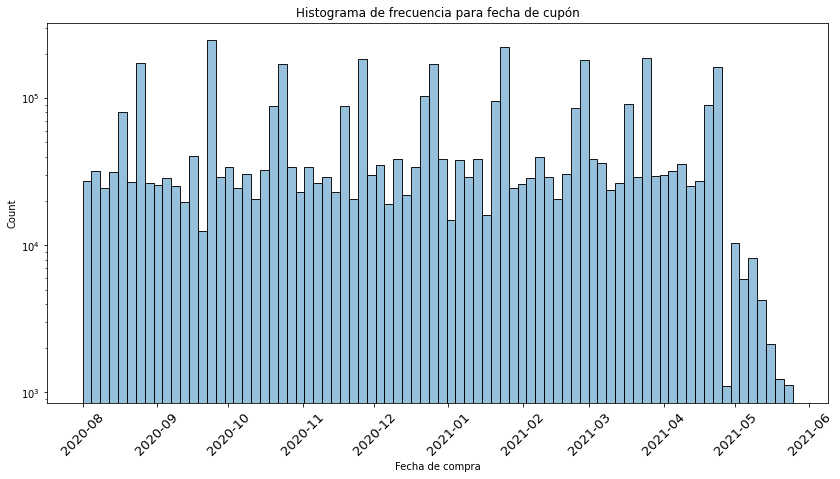

In [94]:
fecha = 'fecha_cupon_movimiento'

fig, ax = plt.subplots(figsize=(14,7))
ax.tick_params(axis='x',rotation = 45,labelsize = 13)
ax.set_xlabel("Fecha de compra")
ax.set_yscale("log")
sns.histplot(data=df, x=fecha, bins=80, color="#3182bd", alpha=0.5)
ax.set_title('Histograma de frecuencia para fecha de cupón')

El grafico nos demuestra que existen algunos casos aislados desde Marzo hasta Julio. Decidimos eliminar estos casos aislados para que en todos los meses analizados exista una cantidad significativa de datos. 

In [90]:
print('Cantidad de casos antes de Abril 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-04-01')]))
print('Cantidad de casos antes de Mayo 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-05-01')]))
print('Cantidad de casos antes de Junio 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-06-01')]))
print('Cantidad de casos antes de Julio 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]))
print('Cantidad de casos antes de Agosto 2020: ', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-08-01')]))

In [92]:
print('Cantidad de casos despues de Abril 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-04-01')]))
print('Cantidad de casos despues de Mayo 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-05-01')]))
print('Cantidad de casos despues de Junio 2021: ', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-06-01')]))

Cantidad de casos despues de Abril 2021:  420667
Cantidad de casos despues de Mayo 2021:  30973
Cantidad de casos despues de Junio 2021:  0


Desde el mes de agosto la cantidad de casos aumenta significativamente en comparacion con los meses anteriores. Para conservar los meses donde hay suficientes transacciones como para obtener datos significativos en las tendencias, filtramos los datos anteriores a Agosto.

Haciendo un calculo similar a los ultimos meses, 

In [93]:
df.loc[:, :] = df[df['fecha_cupon_movimiento'] >= pd.to_datetime('2020-08-01')]
df.loc[:, :] = df[df['fecha_cupon_movimiento'] < pd.to_datetime('2021-06-01')]

### Creacion de dataset a guardar

In [ ]:
# Aca diria que esten todas las operaciones de ppio a fin

### ¿Se puede normalizar la antiguedad y/o monto_compra_movimiento?

In [64]:
#scaled_df = pd.DataFrame(
colums_norm = ["monto_compra_movimiento","antig_cliente"] 
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df[colums_norm])).rename(columns={'0': 'monto_compra_movimiento', '1': 'antig_cliente'})
df_scaled 

,0,1
0,-0.336006,-0.260239
1,-0.334030,-1.396156
2,-0.336016,-0.222375
3,-0.336592,0.484418
4,-0.336670,-0.335967
...,...,...
4092072,-0.336685,-0.664121
4092073,-0.297540,-1.080624
4092074,-0.336281,-1.269943
4092075,-0.334978,-1.244700


In [77]:
monto = df.monto_compra_movimiento.values.copy().reshape(-1,1)
antig = df.antig_cliente.values.copy().reshape(-1,1)
monto_scaled = MinMaxScaler().fit_transform(monto)
antig_scaled = MinMaxScaler().fit_transform(antig)

c:\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Monto escalado')

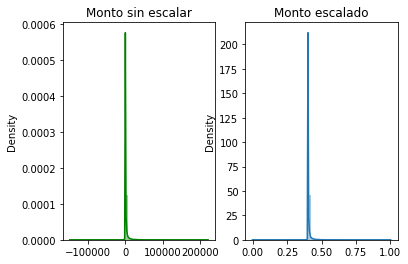

In [81]:
fig, ax=plt.subplots(1,2)
sns.distplot(monto,ax=ax[0],color='Green')
ax[0].set_title("Monto sin escalar")
sns.distplot(monto_scaled, ax=ax[1])
ax[1].set_title("Monto escalado")

c:\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Antiguedad escalado')

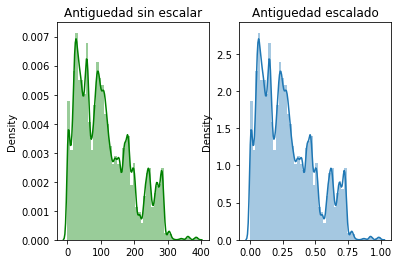

In [82]:
fig, ax=plt.subplots(1,2)
sns.distplot(antig,ax=ax[0],color='Green')
ax[0].set_title("Antiguedad sin escalar")
sns.distplot(antig_scaled, ax=ax[1])
ax[1].set_title("Antiguedad escalado")

### Análisis del PCA

Primero se debe procesar las columnas antes de aplicar el PCA, es decir dejarlas en formato de matríz. Intentamos el cálculo sin estandarizar..

In [7]:
colum_pca = ["monto_compra_movimiento", "edad_cliente","antig_cliente"] 

In [8]:
df_pca = df[colum_pca]
df_pca = (df_pca).dropna(subset=['edad_cliente'])

In [9]:
df_pca = df_pca.values
df_pca

array([[ 6.24, 61.  , 92.  ],
       [17.73, 29.  ,  2.  ],
       [ 6.18, 28.  , 95.  ],
       ...,
       [ 4.64, 60.  , 12.  ],
       [12.22, 60.  , 14.  ],
       [ 4.95, 60.  , 15.  ]])

In [10]:
pca = PCA(n_components=3)
pca.fit(df_pca)
proyected_features = pca.transform(df_pca)
proyected_features.shape

(4081526, 3)

In [11]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([9.99808355e-01, 1.85889449e-04, 5.75538655e-06])

In [12]:
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

array([ 99.98, 100.  , 100.  ])

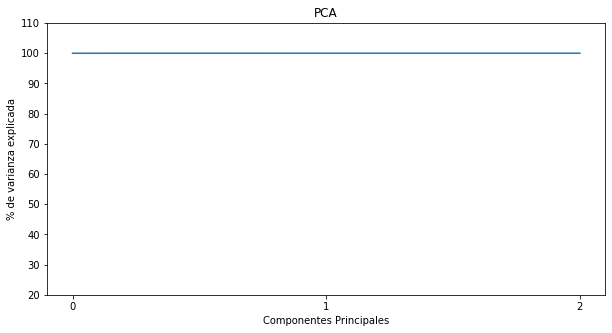

In [13]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca.n_components))
plt.plot(acc_variance_percent)

In [14]:
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

array([ 99.98, 100.  , 100.  ])

Sin estandarizar las variables no llego a encontrar un componente principal.. 

#### Estandarizar/Normalizar antes

In [15]:
df_pca_stand = preprocessing.StandardScaler().fit_transform(df_pca)
df_pca_stand

array([[-0.33588309,  0.78114374, -0.26217146],
       [-0.33390854, -1.33217402, -1.39884821],
       [-0.3358934 , -1.3982152 , -0.22428223],
       ...,
       [-0.33615805,  0.71510256, -1.27255079],
       [-0.33485543,  0.71510256, -1.24729131],
       [-0.33610477,  0.71510256, -1.23466156]])

In [16]:
pca2 = PCA(n_components=3)
pca2.fit(df_pca_stand)
proyected_features_2 = pca2.transform(df_pca_stand)
proyected_features_2.shape

(4081526, 3)

In [17]:
explained_variance_2 = pca2.explained_variance_ratio_
explained_variance_2

array([0.46059612, 0.33364993, 0.20575395])

In [18]:
acc_variance_percent_2 = np.cumsum(np.round(explained_variance_2, decimals=4) * 100)
acc_variance_percent_2

array([ 46.06,  79.42, 100.  ])

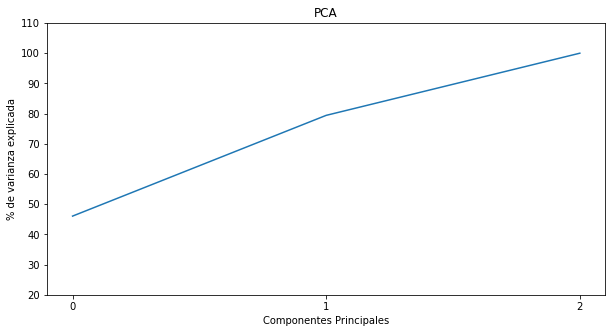

In [19]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca2.n_components))
plt.plot(acc_variance_percent_2)

In [20]:
df_pca_final = df[colum_pca]
df_pca_final = (df_pca_final).dropna(subset=['edad_cliente'])
df_pca_final[["pca1","pca2"]] = proyected_features_2[:,:2]
df_pca_final

,monto_compra_movimiento,edad_cliente,antig_cliente,pca1,pca2
0,6.24,61.0,92,0.345985,-0.410213
1,17.73,29.0,2,-1.946914,-0.227610
2,6.18,28.0,95,-1.162565,-0.207920
3,2.83,39.0,151,-0.150433,-0.266396
4,2.38,36.0,86,-0.870812,-0.258997
...,...,...,...,...,...
4092072,2.29,70.0,60,0.478749,-0.471276
4092073,229.90,29.0,27,-1.721484,-0.187128
4092074,4.64,60.0,12,-0.415383,-0.417749
4092075,12.22,60.0,14,-0.397439,-0.416117


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

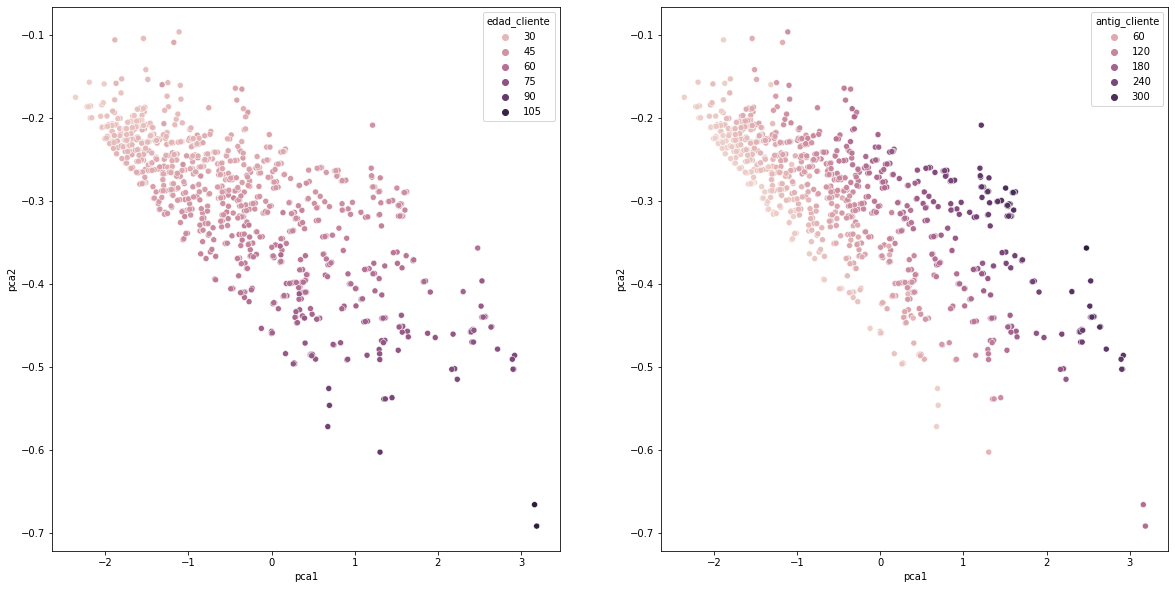

In [98]:
cols = ['edad_cliente', 'antig_cliente']
data = df_pca_final[cols + ['pca1', 'pca2']][:1000].dropna(how='any')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='edad_cliente', ax=axes[0])  
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='antig_cliente', ax=axes[1]) 

## 4. Guardado
* Eliminar las columnas/filas que se concideren no necesarias, explicando el por que
* Codificar variables: todas las variables categóricas deben guardarse como variables numéricas, no string
* Comprimir el conjunto de datos para que se guarde en el formato más eficiente y comparalo contra `csv`.

## 5. Optativos
En Big data se manejan datos crudos todo el tiempo y de gran volumen, este proceso de exploracion y limpieza
es parte del proceso conocido como ETL (Extract, transform, load) o ELT (Extract, load, transform). 
Todo el proceso de este tp pertenece a la etapa de Transfom. En big data esto se hace de manera automatizada. 

* Entonces como asegurarse que los datos son saludables?.
  Es decir que no contengan valores atipicos, nulls, tipos de datos incorrectos, etc.
  No podemos hacer validaciones a mano si tenemos miles de datos por dia/hora.
  > Hint: [great expectations](https://greatexpectations.io/)
* Documentar las columnas finales. (procesos aplicados en este tp)
